In [134]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import median_filter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [4]:
# conv = vgg16.features[19].cuda()

# img_size = (1, 3, 224, 224)
# img = torch.rand(size=img_size, requires_grad=False).cuda()
# img = (img - 0.5) * 20 + 128

# random_img = Variable(img, requires_grad=True)
# random_img = random_img.cuda() if True else random_img

# out = conv(imgs[3]).cuda()
# loss = out[0, 3, :, :].mean().cuda()
# loss.backward()
# plt.imshow(out[0, 3].cpu().detach().numpy())
# conv.weight[0].shape

In [37]:
def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose(1, 2, 0)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [38]:
def normalize(grad):
    norm_grad = torch.sqrt(
        (grad**2).mean()) + 1e-5
    return grad/norm_grad

In [243]:
def gradient_ascent(img, kernel_index, steps=20, learning_rate=1.0, 
                    conv=None, cuda=True):
    
    denoise_freq = int(steps/4)
    
    for step in range(steps):
        random_img = Variable(img, requires_grad=True)
        random_img = random_img.cuda() if cuda else random_img
        
        out = F.relu(conv(random_img)).cuda()
        out = out.cuda() if cuda else out
        
        loss = out[:, kernel_index, :, :].mean().cuda()
        loss = loss.cuda() if cuda else loss
        loss.backward()
        
        # Normilize gradients
        norm_grad = normalize(random_img.grad)
        
        img += norm_grad * lr
        
        if step%denoise_freq == 0:
            # Denoise image
            denoised_img = median_filter(img.cpu().numpy(), size=(1,3,3,3))
            denoised_img = torch.tensor(denoised_img)
            denoised_img = denoised_img.cuda() if cuda else denoised_img
            img *= 0 
            img += denoised_img
            
        # if loss.item() <= 1e-07:
        #    return None
        
    return img, loss.item()

In [244]:
data_path = '/media/gabriel/External 2.0 TB/ImageNet/1000_classes'
classes = next(os.walk(data_path, topdown=True))[1]
classes.sort()

len(classes)

977

In [245]:
tmp = torch.rand(size=(2,2))
tmp2 = Variable(tmp, requires_grad=True)
# tmp *= 0
# tmp += 1
tmp.numpy()

array([[0.5464211 , 0.773933  ],
       [0.72946507, 0.10197973]], dtype=float32)

In [216]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [217]:
# Block 1
conv_1_1 = vgg16.features[0:2]
conv_1_2 = vgg16.features[:5]

# Block 2
conv_2_1 = vgg16.features[:7]
conv_2_2 = vgg16.features[:10]

# Block 3
conv_3_1 = vgg16.features[:12]
conv_3_2 = vgg16.features[:14]
conv_3_3 = vgg16.features[:17]

# Block 4
conv_4_1 = vgg16.features[:19]
conv_4_2 = vgg16.features[:21]
conv_4_3 = vgg16.features[:24]

# Block 5
conv_5_1 = vgg16.features[:26]
conv_5_2 = vgg16.features[:28]
conv_5_3 = vgg16.features[:31]

conv_2_1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
)

In [218]:
imagenet_data = datasets.ImageFolder(
        data_path, 
        transform=transforms.Compose([
            transforms.RandomCrop(22deprocess_image4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
#               transforms.Normalize(mean=[0],
#                                    std=[1])
            
        ]))
data_loader = DataLoader(
        imagenet_data, batch_size=5,
        shuffle=True, num_workers=4)

data_loader_iter = iter(data_loader)

In [219]:
images, labels = next(data_loader_iter)
image = images[0].numpy().transpose(1,2,0)
label = labels[0].item()

print(images.shape)
print(labels.shape)

torch.Size([5, 3, 224, 224])
torch.Size([5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:tile roof, Value:889


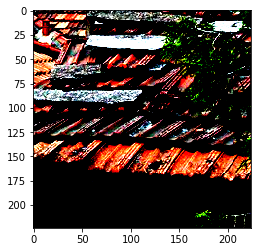

In [220]:
print('Class:%s, ' % classes[label] + 'Value:%s' % label)
plt.imshow(image)
plt.show()

In [251]:
lr = 1.0
kernel_index = 10

conv = conv_5_1.cuda()
num_of_kernels = conv[-2].weight.shape[0]

img_size = (1, 3, 224, 224)
imgs = []

costs = []

for kernel_index in range(num_of_kernels):
    # Create a random image
    img = torch.rand(size=img_size, 
                     requires_grad=False).cuda()
    # Add noise to the image
    img = (img - 0.5) * 20 + 128
    
    # Gradient Ascent
    img, loss = gradient_ascent(img, kernel_index, steps=40, conv=conv)
    
    if img is not None:
        imgs.append(img)
        costs.append([kernel_index, loss])
    
    print( f'Filter: {kernel_index},' + f' Loss: {loss:.4f} ')
#     print(f'img.average(): {norm_grad.mean():.5}')

Filter: 0, Loss: 201.7253 
Filter: 1, Loss: 0.0000 
Filter: 2, Loss: 0.0000 
Filter: 3, Loss: 0.0000 
Filter: 4, Loss: 623.3019 
Filter: 5, Loss: 198.8038 
Filter: 6, Loss: 0.0000 
Filter: 7, Loss: 133.3981 
Filter: 8, Loss: 86.8086 
Filter: 9, Loss: 372.7650 
Filter: 10, Loss: 1012.6698 
Filter: 11, Loss: 222.9274 
Filter: 12, Loss: 0.0000 
Filter: 13, Loss: 0.0000 
Filter: 14, Loss: 188.0848 
Filter: 15, Loss: 131.3220 
Filter: 16, Loss: 107.5200 
Filter: 17, Loss: 497.9052 
Filter: 18, Loss: 0.0000 
Filter: 19, Loss: 0.0000 
Filter: 20, Loss: 222.7366 
Filter: 21, Loss: 78.4383 
Filter: 22, Loss: 0.0000 
Filter: 23, Loss: 530.6686 
Filter: 24, Loss: 287.8044 
Filter: 25, Loss: 251.7182 
Filter: 26, Loss: 249.5739 
Filter: 27, Loss: 405.5298 
Filter: 28, Loss: 764.3511 
Filter: 29, Loss: 0.0000 
Filter: 30, Loss: 208.7183 
Filter: 31, Loss: 0.0000 
Filter: 32, Loss: 125.1103 
Filter: 33, Loss: 346.4758 
Filter: 34, Loss: 0.0000 
Filter: 35, Loss: 529.5932 
Filter: 36, Loss: 1525.8944

Filter: 293, Loss: 467.0677 
Filter: 294, Loss: 0.0000 
Filter: 295, Loss: 477.1351 
Filter: 296, Loss: 121.3782 
Filter: 297, Loss: 204.3894 
Filter: 298, Loss: 401.8755 
Filter: 299, Loss: 70.4224 
Filter: 300, Loss: 399.1538 
Filter: 301, Loss: 0.0000 
Filter: 302, Loss: 338.3616 
Filter: 303, Loss: 0.0000 
Filter: 304, Loss: 195.0765 
Filter: 305, Loss: 452.6227 
Filter: 306, Loss: 0.0000 
Filter: 307, Loss: 0.0000 
Filter: 308, Loss: 0.0000 
Filter: 309, Loss: 305.0113 
Filter: 310, Loss: 176.5777 
Filter: 311, Loss: 1069.7463 
Filter: 312, Loss: 47.0726 
Filter: 313, Loss: 0.0000 
Filter: 314, Loss: 0.0000 
Filter: 315, Loss: 60.5541 
Filter: 316, Loss: 341.1049 
Filter: 317, Loss: 1394.5718 
Filter: 318, Loss: 105.6975 
Filter: 319, Loss: 290.2059 
Filter: 320, Loss: 54.3464 
Filter: 321, Loss: 238.4442 
Filter: 322, Loss: 0.0000 
Filter: 323, Loss: 327.8279 
Filter: 324, Loss: 79.7532 
Filter: 325, Loss: 0.0000 
Filter: 326, Loss: 684.4388 
Filter: 327, Loss: 585.0410 
Filter: 

In [ ]:
# for kernel in imgs:
#     kernel = img[0].cpu().detach().numpy().transpose(1,2,0)
# #     kernel -= kernel.mean()
# #     kernel /= (kernel.std() + 1e-5)
# #     kernel *= 0.25

# #     # clip to [0, 1]
# #     kernel += 0.5
# #     kernel = np.clip(kernel, 0, 1)

# #     # convert to RGB array
# #     kernel *= 255
#     kernel = np.clip(kernel, 0, 255).astype('uint8')

#     plt.imshow(kernel)
#     plt.show()

In [108]:
# tmp = imgs[29][0]

# cols = 4
# rows = int(len(tmp)/cols)
# figsize = (15, 68) # width, height

# fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
# axs = axs.flatten()

# for index, ax in enumerate(axs):
#     kernel = tmp[index].cpu().detach().numpy()
# #     kernel = kernel.transpose(1, 2, 0)
#     kernel = np.clip(kernel, 0, 255).astype('uint8')
#     ax.set_title("Index: %s" % index)
#     ax.imshow(kernel)

# Show top-10

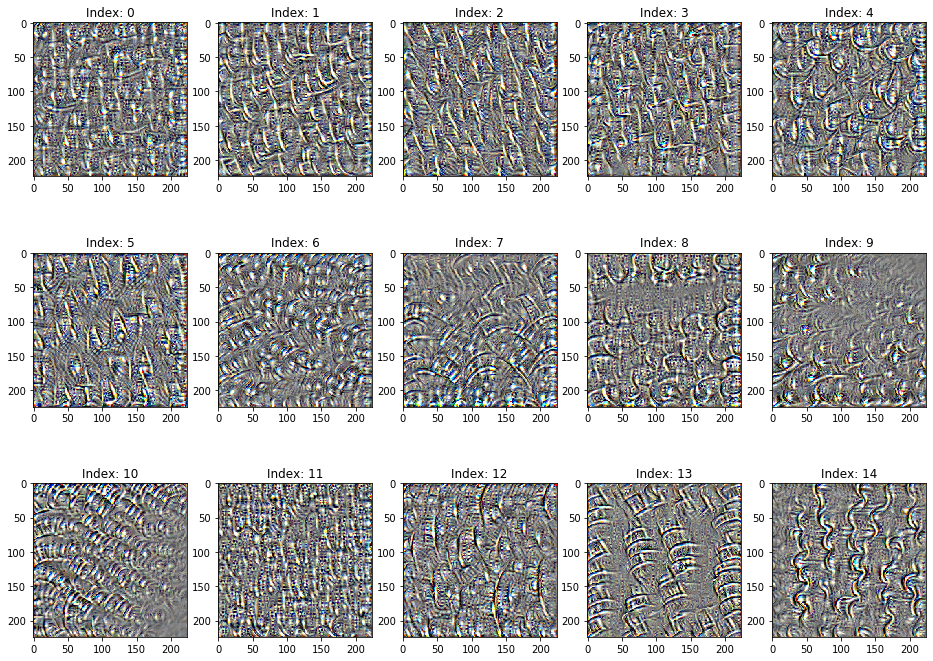

In [259]:
costs.sort(key=lambda x:x[1], reverse=True)

cols = 5
rows = 3
figsize = (16, 12) # width, height

fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
axs = axs.flatten()

for index, ax in enumerate(axs):
    kernel_index = costs[index][0] 
    kernel = imgs[kernel_index].cpu().detach().numpy()[0]
    kernel = deprocess_image(kernel)
    kernel = np.clip(kernel, 0, 255).astype('uint8')
    ax.set_title("Index: %s" % (index))
    ax.imshow(kernel)

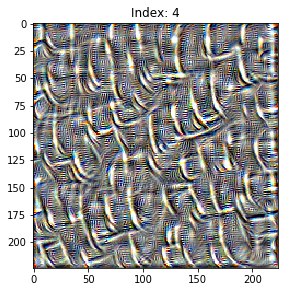

In [255]:
cols = 1
rows = 1
figsize = (4.5, 4.5) # width, height

fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
ax = ax.flatten()

index = costs[1][0] 

kernel = imgs[index].cpu().detach().numpy()[0]
kernel = deprocess_image(kernel)
ax[0].set_title("Index: %s" % 4)
ax[0].imshow(kernel)
plt.show()

In [258]:
costs

[[36, 1525.8944091796875],
 [379, 1523.4127197265625],
 [317, 1394.57177734375],
 [339, 1222.6640625],
 [65, 1128.0816650390625],
 [381, 1094.9703369140625],
 [311, 1069.746337890625],
 [139, 1069.4776611328125],
 [111, 1061.4837646484375],
 [78, 1052.187255859375],
 [333, 1017.482666015625],
 [10, 1012.6697998046875],
 [106, 1006.5747680664062],
 [451, 993.6461791992188],
 [244, 971.121337890625],
 [468, 950.626708984375],
 [179, 940.8115844726562],
 [187, 915.9852294921875],
 [280, 863.4036865234375],
 [257, 862.2235107421875],
 [402, 851.9573974609375],
 [108, 841.400146484375],
 [414, 839.7520751953125],
 [216, 795.6583251953125],
 [37, 790.0291748046875],
 [432, 790.0092163085938],
 [184, 786.2708740234375],
 [121, 775.2698974609375],
 [73, 765.6034545898438],
 [28, 764.3511352539062],
 [507, 760.6881713867188],
 [378, 750.343505859375],
 [422, 733.0195922851562],
 [174, 725.4970092773438],
 [510, 724.25048828125],
 [138, 720.7982788085938],
 [336, 716.2935791015625],
 [351, 710.7